# Torch with Pretrained Weigths and Encoder

### In this project, my purpose is to applying segmentation to water bodies. Feel free to check my repo on github...

### https://github.com/uraninjo/SatelliteWaterBodies



In [1]:
# !pip install --upgrade opencv-contrib-python
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

height,width = (256, 256)
IMAGE_SHAPE = (256, 256)
dataset_length = 1556
torch.cuda.is_available()

True

**Before our model preperation, we need to edit the data and we need to make the photo the shape we want for our model.**

**For this, we create a class for ourselves and write the functions we want in it.**

**We load the data with glob as X-Y...**

In [80]:
# X = sorted(glob.glob('imgs/*'))
# y = sorted(glob.glob('masks/*'))
# print(len(y))

**We need to check the existence of the data we are uploading. If a wrong path is entered here, our result below will be 0.**

**We seperate our data for train and validation and shape it with our above class.**

In [81]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [82]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import IterableDataset
import albumentations as A
import tifffile as tiff

# Define your custom dataset class
class CustomIterableDataset(IterableDataset):
    def __init__(self, base_path, json_data, subset, width=256, height=256, transform=None):
        self.base_path = base_path
        self.json_data = json_data
        self.subset = subset
        self.width = width
        self.height = height
        self.transform = transform
    
    def _load_and_process_images_from_folder(self, folder):
        images = []
        for filename in sorted(os.listdir(folder)):
            img_path = os.path.join(folder, filename)
            img = tiff.imread(img_path) if img_path.lower().endswith('.tif') else np.array(Image.open(img_path))
            if img.ndim == 3 and img.shape[2] > 3:  # Handle RGBA images
                img = img[:, :, :3]
            img = self._resize_image(img)
            images.append(img)
        return np.array(images)
    
    def _resize_image(self, image):
        # Ensure the image is in the correct format for PIL
        if image.dtype != np.uint8:
            image = (255 * image).astype(np.uint8)
        image = Image.fromarray(image)
        image = image.resize((self.width, self.height))
        return np.array(image)

    def _normalize_min_max(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val)
    
    def _process_data(self, folder_name):
        flood_path = os.path.join(self.base_path, folder_name)
        s1_path = os.path.join(flood_path, 's1_raw')
        mask_path = os.path.join(flood_path, 'mask')
        dem_path = os.path.join(flood_path, 'DEM')

        try:
            s1_images = self._load_and_process_images_from_folder(s1_path)
            masks = self._load_and_process_images_from_folder(mask_path)
            dems = self._load_and_process_images_from_folder(dem_path)
        except Exception as e:
            print(f"Error loading images from {folder_name}: {e}")
            return

        for i in range(len(s1_images)):
            if s1_images[i].shape[:2] != masks[i].shape[:2]:
                continue
            if np.all(masks[i] == 0):
                continue
            
            s1_image = self._normalize_min_max(s1_images[i])
            mask = self._normalize_min_max(masks[i])
            dem = self._normalize_min_max(dems[i])
            input_image = np.stack((s1_image[:, :, 0], s1_image[:, :, 1], dem[:, :]), axis=-1)
            
            if self.transform:
                augmented = self.transform(image=input_image, mask=mask)
                input_image = augmented['image']
                mask = augmented['mask']
            
            yield {"images": torch.tensor(input_image, dtype=torch.float32).permute(2, 0, 1),
                   "segmentation_masks": torch.tensor(mask, dtype=torch.float32).unsqueeze(0)}

    def __iter__(self):
        for key, value in self.json_data.items():
            if value['subset'] == self.subset:
                prefix = key
                folder_names = [f for f in os.listdir(self.base_path) if f.startswith(prefix)]
                
                for folder_name in folder_names:
                    yield from self._process_data(folder_name)

In [83]:
# Define transformations
transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

base_path = 'mmflood\mmflood'

import json
def load_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

json_data = load_json('mmflood/activations.json')  # Load or define your json_data here
subset = 'train'  # Example subset

train_dataset = CustomIterableDataset(base_path=base_path, json_data=json_data, subset='train', width=256, height=256, transform=transform)
valid_dataset = CustomIterableDataset(base_path=base_path, json_data=json_data, subset='test', width=256, height=256, transform=transform)

torch.Size([1, 256, 256])


Text(0.5, 1.0, 'mask')

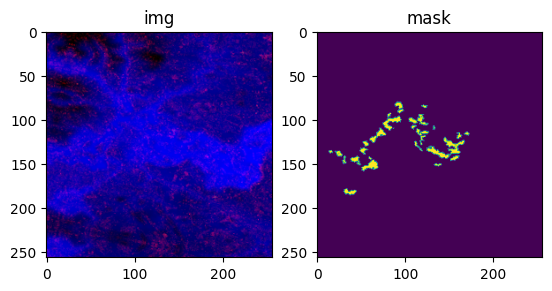

In [84]:
import matplotlib.pyplot as plt
iterator = iter(train_dataset)
sample = next(iterator)
img = sample["images"]
mask = sample["segmentation_masks"]
print(np.shape(mask))
f, axarr = plt.subplots(1,2) 
axarr[0].set_title('img')
axarr[0].imshow(np.transpose(img, (1, 2, 0)))
axarr[1].imshow(np.squeeze(mask.numpy()))
axarr[1].set_title('mask')


**This settings are customizable you could change it as you want. Encoder selection is important, your results will be according to it...**

In [85]:
DEVICE='cuda'

EPOCHS=12
BATCH_SIZE=10
LR=0.001

ratio=0.3 #Various ratios could perform better for visualization
sample_num=0

ENCODER='resnet50'
WEIGHTS='imagenet'

**We load the data with DataLoader...**

In [86]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
)

**Here we determine the encoder and weights from the above variables in Unet.**

**The value of our loss function is the sum of the DiceLoss and BCEWithLogitsLoss.**

In [87]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [88]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [89]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

**We write the function to be used for training and eval so that things are simplified in the training cycle.**

In [90]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for batch in tqdm(data_loader):
        images = batch['images'].to(DEVICE, dtype=torch.float32)
        masks = batch['segmentation_masks'].to(DEVICE, dtype=torch.float32)
        optimizer.zero_grad()
        logits,diceloss,bceloss=model(images,masks)

        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/dataset_length,total_bceloss/dataset_length

In [91]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for batch in tqdm(data_loader):
            images = batch['images'].to(DEVICE, dtype=torch.float32)
            masks = batch['segmentation_masks'].to(DEVICE, dtype=torch.float32)
            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            data_iteration=next(iter(valid_loader))
            logits_mask=model(data_iteration["images"][0].to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[0].imshow(np.transpose(data_iteration["images"][0].numpy(), (1,2,0)))
            axarr[1].imshow(np.squeeze(data_iteration["segmentation_masks"][0].numpy()), cmap='gray')
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/dataset_length,total_bceloss/dataset_length


In [92]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)#torch.optim.Adam(model.parameters(),lr=LR)

**We use the adam optimizer and set up our training loop.**

**Here we want to save the best model and see our loss at every step...**

3it [00:05,  1.86s/it]C:\Users\Orlan\AppData\Local\Temp\ipykernel_9628\34165948.py:33: RuntimeWarning: invalid value encountered in cast
  image = (255 * image).astype(np.uint8)
124it [04:32,  2.20s/it]
1it [00:01,  1.63s/it]

Dice Loss: tensor(0.9734, device='cuda:0')
BCE Loss: tensor(0.1541, device='cuda:0')


2it [00:02,  1.36s/it]

Dice Loss: tensor(0.9484, device='cuda:0')
BCE Loss: tensor(0.1423, device='cuda:0')
Dice Loss: 

3it [00:09,  3.70s/it]

tensor(0.8642, device='cuda:0')
BCE Loss: tensor(0.2685, device='cuda:0')
Dice Loss: 

4it [00:09,  2.36s/it]

tensor(0.8620, device='cuda:0')
BCE Loss: tensor(0.3118, device='cuda:0')
Dice Loss: tensor(0.9632, device='cuda:0')
BCE Loss: 

5it [00:11,  2.32s/it]

tensor(0.1144, device='cuda:0')
Dice Loss: 

6it [00:14,  2.32s/it]

tensor(0.9662, device='cuda:0')
BCE Loss: tensor(0.1281, device='cuda:0')


7it [00:15,  2.08s/it]

Dice Loss: tensor(0.9755, device='cuda:0')
BCE Loss: tensor(0.1172, device='cuda:0')


8it [00:16,  1.60s/it]

Dice Loss: tensor(0.9354, device='cuda:0')
BCE Loss: tensor(0.1419, device='cuda:0')
Dice Loss: 

9it [00:18,  1.80s/it]

tensor(0.9494, device='cuda:0')
BCE Loss: tensor(0.1407, device='cuda:0')


10it [00:19,  1.57s/it]

Dice Loss: tensor(0.9471, device='cuda:0')
BCE Loss: tensor(0.1565, device='cuda:0')
Dice Loss: 

11it [00:22,  1.84s/it]

tensor(0.9805, device='cuda:0')
BCE Loss: tensor(0.0996, device='cuda:0')


12it [00:23,  1.83s/it]

Dice Loss: tensor(0.9101, device='cuda:0')
BCE Loss: tensor(0.1292, device='cuda:0')
Dice Loss: 

13it [00:28,  2.72s/it]

tensor(0.9781, device='cuda:0')
BCE Loss: tensor(0.0881, device='cuda:0')


14it [00:29,  2.14s/it]

Dice Loss: tensor(0.9571, device='cuda:0')
BCE Loss: tensor(0.1220, device='cuda:0')
Dice Loss: 

15it [00:32,  2.36s/it]

tensor(0.9706, device='cuda:0')
BCE Loss: tensor(0.1104, device='cuda:0')


16it [00:33,  1.97s/it]

Dice Loss: tensor(0.9419, device='cuda:0')
BCE Loss: tensor(0.1370, device='cuda:0')


17it [00:34,  1.70s/it]

Dice Loss: tensor(0.9774, device='cuda:0')
BCE Loss: tensor(0.1130, device='cuda:0')


18it [00:35,  1.45s/it]

Dice Loss: tensor(0.9772, device='cuda:0')
BCE Loss: tensor(0.1245, device='cuda:0')


19it [00:36,  1.32s/it]

Dice Loss: tensor(0.9606, device='cuda:0')
BCE Loss: tensor(0.1522, device='cuda:0')


20it [00:37,  1.19s/it]

Dice Loss: tensor(0.9505, device='cuda:0')
BCE Loss: tensor(0.1400, device='cuda:0')
Dice Loss: 

21it [00:39,  1.53s/it]

tensor(0.9508, device='cuda:0')
BCE Loss: tensor(0.1385, device='cuda:0')


22it [00:39,  1.20s/it]

Dice Loss: tensor(0.8816, device='cuda:0')
BCE Loss: tensor(0.2437, device='cuda:0')


23it [00:41,  1.29s/it]

Dice Loss: tensor(0.9397, device='cuda:0')
BCE Loss: tensor(0.1690, device='cuda:0')
Dice Loss: 

24it [00:46,  2.27s/it]

tensor(0.9332, device='cuda:0')
BCE Loss: tensor(0.2161, device='cuda:0')
Dice Loss: 

25it [00:48,  2.29s/it]

tensor(0.9604, device='cuda:0')
BCE Loss: tensor(0.1536, device='cuda:0')


26it [00:50,  2.16s/it]

Dice Loss: tensor(0.9526, device='cuda:0')
BCE Loss: tensor(0.1362, device='cuda:0')
Dice Loss: 

27it [00:53,  2.54s/it]

tensor(0.9153, device='cuda:0')
BCE Loss: tensor(0.2192, device='cuda:0')


28it [00:55,  2.37s/it]

Dice Loss: tensor(0.9140, device='cuda:0')
BCE Loss: tensor(0.2975, device='cuda:0')
Dice Loss: 

29it [00:57,  2.37s/it]

tensor(0.9197, device='cuda:0')
BCE Loss: tensor(0.2647, device='cuda:0')


30it [00:59,  2.17s/it]

Dice Loss: tensor(0.9523, device='cuda:0')
BCE Loss: tensor(0.1306, device='cuda:0')
Dice Loss: tensor(0.9372, device='cuda:0')
BCE Loss: tensor(0.1563, device='cuda:0')


31it [01:01,  2.16s/it]

Dice Loss: 

32it [01:03,  2.15s/it]

tensor(0.9754, device='cuda:0')
BCE Loss: tensor(0.0892, device='cuda:0')


33it [01:05,  2.05s/it]

Dice Loss: tensor(0.9578, device='cuda:0')
BCE Loss: tensor(0.1165, device='cuda:0')
Dice Loss: 

34it [01:10,  2.71s/it]

tensor(0.9943, device='cuda:0')
BCE Loss: tensor(0.0757, device='cuda:0')


35it [01:10,  2.00s/it]

Dice Loss: tensor(0.9905, device='cuda:0')
BCE Loss: tensor(0.0888, device='cuda:0')


36it [01:12,  1.90s/it]

Dice Loss: tensor(0.9602, device='cuda:0')
BCE Loss: tensor(0.1010, device='cuda:0')


37it [01:13,  1.85s/it]

Dice Loss: tensor(0.9472, device='cuda:0')
BCE Loss: tensor(0.1558, device='cuda:0')


38it [01:14,  1.63s/it]

Dice Loss: tensor(0.9427, device='cuda:0')
BCE Loss: tensor(0.2264, device='cuda:0')


39it [01:15,  1.93s/it]

Dice Loss: tensor(0.9703, device='cuda:0')
BCE Loss: tensor(0.1159, device='cuda:0')


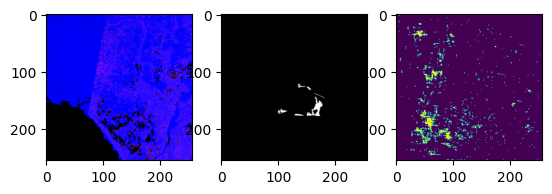

Epochs:1
Train_loss --> Dice: 0.0755021292093787 BCE: 0.022696930441076468 
Valid_loss --> Dice: 0.02376856335024601 BCE: 0.003847283371041857
BEST EPOCH - Model Saved


124it [05:05,  2.46s/it]
1it [00:01,  1.46s/it]

Dice Loss: tensor(0.9708, device='cuda:0')
BCE Loss: tensor(0.1622, device='cuda:0')


2it [00:02,  1.11s/it]

Dice Loss: tensor(0.9233, device='cuda:0')
BCE Loss: tensor(0.1201, device='cuda:0')
Dice Loss: 

3it [00:06,  2.30s/it]

tensor(0.7985, device='cuda:0')
BCE Loss: tensor(0.2377, device='cuda:0')
Dice Loss: 

4it [00:06,  1.50s/it]

tensor(0.8066, device='cuda:0')
BCE Loss: tensor(0.2738, device='cuda:0')


5it [00:07,  1.43s/it]

Dice Loss: tensor(0.9614, device='cuda:0')
BCE Loss: tensor(0.0877, device='cuda:0')


6it [00:09,  1.58s/it]

Dice Loss: tensor(0.9604, device='cuda:0')
BCE Loss: tensor(0.1072, device='cuda:0')


7it [00:10,  1.51s/it]

Dice Loss: tensor(0.9660, device='cuda:0')
BCE Loss: tensor(0.0983, device='cuda:0')


8it [00:11,  1.20s/it]

Dice Loss: tensor(0.8837, device='cuda:0')
BCE Loss: tensor(0.1192, device='cuda:0')


9it [00:12,  1.30s/it]

Dice Loss: tensor(0.8935, device='cuda:0')
BCE Loss: tensor(0.1083, device='cuda:0')


10it [00:13,  1.21s/it]

Dice Loss: tensor(0.9466, device='cuda:0')
BCE Loss: tensor(0.1658, device='cuda:0')


11it [00:15,  1.23s/it]

Dice Loss: tensor(0.9789, device='cuda:0')
BCE Loss: tensor(0.1098, device='cuda:0')


12it [00:15,  1.09s/it]

Dice Loss: tensor(0.8371, device='cuda:0')
BCE Loss: tensor(0.1040, device='cuda:0')
Dice Loss: 

13it [00:18,  1.45s/it]

tensor(0.9584, device='cuda:0')
BCE Loss: tensor(0.0746, device='cuda:0')


14it [00:18,  1.15s/it]

Dice Loss: tensor(0.9401, device='cuda:0')
BCE Loss: tensor(0.1051, device='cuda:0')
Dice Loss: 

15it [00:20,  1.47s/it]

tensor(0.9419, device='cuda:0')
BCE Loss: tensor(0.0794, device='cuda:0')


16it [00:22,  1.49s/it]

Dice Loss: tensor(0.9174, device='cuda:0')
BCE Loss: tensor(0.1091, device='cuda:0')


17it [00:24,  1.56s/it]

Dice Loss: tensor(0.9636, device='cuda:0')
BCE Loss: tensor(0.0889, device='cuda:0')


18it [00:25,  1.56s/it]

Dice Loss: tensor(0.9691, device='cuda:0')
BCE Loss: tensor(0.0936, device='cuda:0')


19it [00:26,  1.45s/it]

Dice Loss: tensor(0.9392, device='cuda:0')
BCE Loss: tensor(0.1661, device='cuda:0')


20it [00:27,  1.30s/it]

Dice Loss: tensor(0.9273, device='cuda:0')
BCE Loss: tensor(0.1377, device='cuda:0')
Dice Loss: 

21it [00:29,  1.53s/it]

tensor(0.9101, device='cuda:0')
BCE Loss: tensor(0.1188, device='cuda:0')


22it [00:30,  1.20s/it]

Dice Loss: tensor(0.8153, device='cuda:0')
BCE Loss: tensor(0.2239, device='cuda:0')


23it [00:31,  1.25s/it]

Dice Loss: tensor(0.9183, device='cuda:0')
BCE Loss: tensor(0.1728, device='cuda:0')
Dice Loss: 

24it [00:33,  1.49s/it]

tensor(0.9202, device='cuda:0')
BCE Loss: tensor(0.2201, device='cuda:0')


25it [00:34,  1.40s/it]

Dice Loss: tensor(0.9506, device='cuda:0')
BCE Loss: tensor(0.1366, device='cuda:0')


26it [00:36,  1.41s/it]

Dice Loss: tensor(0.9246, device='cuda:0')
BCE Loss: tensor(0.1274, device='cuda:0')
Dice Loss: 

27it [00:39,  1.82s/it]

tensor(0.9095, device='cuda:0')
BCE Loss: tensor(0.2187, device='cuda:0')


28it [00:40,  1.69s/it]

Dice Loss: tensor(0.9084, device='cuda:0')
BCE Loss: tensor(0.2854, device='cuda:0')


29it [00:42,  1.63s/it]

Dice Loss: tensor(0.8848, device='cuda:0')
BCE Loss: tensor(0.2470, device='cuda:0')


30it [00:43,  1.48s/it]

Dice Loss: tensor(0.9320, device='cuda:0')
BCE Loss: tensor(0.1095, device='cuda:0')


31it [00:44,  1.45s/it]

Dice Loss: tensor(0.8987, device='cuda:0')
BCE Loss: tensor(0.1511, device='cuda:0')


32it [00:46,  1.45s/it]

Dice Loss: tensor(0.9596, device='cuda:0')
BCE Loss: tensor(0.0682, device='cuda:0')


33it [00:47,  1.36s/it]

Dice Loss: tensor(0.9364, device='cuda:0')
BCE Loss: tensor(0.1059, device='cuda:0')
Dice Loss: 

34it [00:49,  1.78s/it]

tensor(0.9941, device='cuda:0')
BCE Loss: tensor(0.0678, device='cuda:0')
Dice Loss: 

35it [00:50,  1.32s/it]

tensor(0.9863, device='cuda:0')
BCE Loss: tensor(0.0716, device='cuda:0')


36it [00:51,  1.22s/it]

Dice Loss: tensor(0.9319, device='cuda:0')
BCE Loss: tensor(0.0943, device='cuda:0')


37it [00:52,  1.30s/it]

Dice Loss: tensor(0.9318, device='cuda:0')
BCE Loss: tensor(0.1415, device='cuda:0')


38it [00:53,  1.23s/it]

Dice Loss: tensor(0.9349, device='cuda:0')
BCE Loss: tensor(0.2185, device='cuda:0')


39it [00:54,  1.39s/it]

Dice Loss: tensor(0.9535, device='cuda:0')
BCE Loss: tensor(0.0968, device='cuda:0')


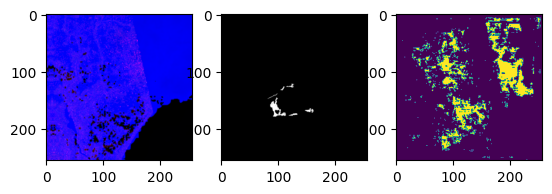

Epochs:2
Train_loss --> Dice: 0.07497109637468824 BCE: 0.012150517394311324 
Valid_loss --> Dice: 0.0231907157787627 BCE: 0.0034861790499910905
BEST EPOCH - Model Saved


124it [04:39,  2.25s/it]
1it [00:02,  2.16s/it]

Dice Loss: tensor(0.9623, device='cuda:0')
BCE Loss: tensor(0.1928, device='cuda:0')


2it [00:03,  1.90s/it]

Dice Loss: tensor(0.8975, device='cuda:0')
BCE Loss: tensor(0.1129, device='cuda:0')
Dice Loss: 

3it [00:09,  3.59s/it]

tensor(0.7756, device='cuda:0')
BCE Loss: tensor(0.2346, device='cuda:0')
Dice Loss: 

4it [00:09,  2.28s/it]

tensor(0.7561, device='cuda:0')
BCE Loss: tensor(0.2519, device='cuda:0')
Dice Loss: 

5it [00:12,  2.32s/it]

tensor(0.9492, device='cuda:0')
BCE Loss: tensor(0.0721, device='cuda:0')
Dice Loss: 

6it [00:15,  2.59s/it]

tensor(0.9088, device='cuda:0')
BCE Loss: tensor(0.0896, device='cuda:0')
Dice Loss: 

7it [00:17,  2.63s/it]

tensor(0.9642, device='cuda:0')
BCE Loss: tensor(0.0927, device='cuda:0')


8it [00:19,  2.15s/it]

Dice Loss: tensor(0.8749, device='cuda:0')
BCE Loss: tensor(0.1103, device='cuda:0')
Dice Loss: 

9it [00:23,  2.91s/it]

tensor(0.8633, device='cuda:0')
BCE Loss: tensor(0.1002, device='cuda:0')


10it [00:26,  2.79s/it]

Dice Loss: tensor(0.9487, device='cuda:0')
BCE Loss: tensor(0.1415, device='cuda:0')
Dice Loss: 

11it [00:29,  2.91s/it]

tensor(0.9777, device='cuda:0')
BCE Loss: tensor(0.0935, device='cuda:0')


12it [00:30,  2.45s/it]

Dice Loss: tensor(0.7958, device='cuda:0')
BCE Loss: tensor(0.0985, device='cuda:0')
Dice Loss: 

13it [00:33,  2.62s/it]

tensor(0.9592, device='cuda:0')
BCE Loss: tensor(0.0868, device='cuda:0')


14it [00:34,  2.03s/it]

Dice Loss: tensor(0.9142, device='cuda:0')
BCE Loss: tensor(0.1008, device='cuda:0')
Dice Loss: 

15it [00:38,  2.62s/it]

tensor(0.9367, device='cuda:0')
BCE Loss: tensor(0.0963, device='cuda:0')


16it [00:39,  2.28s/it]

Dice Loss: tensor(0.8541, device='cuda:0')
BCE Loss: tensor(0.1022, device='cuda:0')


17it [00:41,  2.11s/it]

Dice Loss: tensor(0.9594, device='cuda:0')
BCE Loss: tensor(0.0772, device='cuda:0')


18it [00:43,  2.01s/it]

Dice Loss: tensor(0.9478, device='cuda:0')
BCE Loss: tensor(0.0979, device='cuda:0')


19it [00:45,  1.93s/it]

Dice Loss: tensor(0.9195, device='cuda:0')
BCE Loss: tensor(0.1335, device='cuda:0')


20it [00:46,  1.76s/it]

Dice Loss: tensor(0.9088, device='cuda:0')
BCE Loss: tensor(0.1378, device='cuda:0')
Dice Loss: 

21it [00:49,  2.15s/it]

tensor(0.8953, device='cuda:0')
BCE Loss: tensor(0.1158, device='cuda:0')


22it [00:50,  1.65s/it]

Dice Loss: tensor(0.7506, device='cuda:0')
BCE Loss: tensor(0.1842, device='cuda:0')
Dice Loss: 

23it [00:52,  1.96s/it]

tensor(0.8911, device='cuda:0')
BCE Loss: tensor(0.1601, device='cuda:0')
Dice Loss: 

24it [00:57,  2.78s/it]

tensor(0.8782, device='cuda:0')
BCE Loss: tensor(0.1739, device='cuda:0')


25it [00:58,  2.38s/it]

Dice Loss: tensor(0.9073, device='cuda:0')
BCE Loss: tensor(0.1254, device='cuda:0')
Dice Loss: tensor(0.8984, device='cuda:0')
BCE Loss: 

26it [01:00,  2.28s/it]

tensor(0.1207, device='cuda:0')
Dice Loss: 

27it [01:03,  2.26s/it]

tensor(0.8190, device='cuda:0')
BCE Loss: tensor(0.1798, device='cuda:0')


28it [01:04,  1.88s/it]

Dice Loss: tensor(0.8509, device='cuda:0')
BCE Loss: tensor(0.2503, device='cuda:0')


29it [01:05,  1.84s/it]

Dice Loss: tensor(0.8566, device='cuda:0')
BCE Loss: tensor(0.2496, device='cuda:0')


30it [01:07,  1.78s/it]

Dice Loss: tensor(0.9032, device='cuda:0')
BCE Loss: tensor(0.1080, device='cuda:0')
Dice Loss: 

31it [01:10,  2.03s/it]

tensor(0.8903, device='cuda:0')
BCE Loss: tensor(0.1611, device='cuda:0')


32it [01:11,  1.89s/it]

Dice Loss: tensor(0.9433, device='cuda:0')
BCE Loss: tensor(0.0661, device='cuda:0')


33it [01:13,  1.81s/it]

Dice Loss: tensor(0.9270, device='cuda:0')
BCE Loss: tensor(0.1017, device='cuda:0')
Dice Loss: 

34it [01:16,  2.34s/it]

tensor(0.9879, device='cuda:0')
BCE Loss: tensor(0.0605, device='cuda:0')
Dice Loss: 

35it [01:17,  1.72s/it]

tensor(0.9817, device='cuda:0')
BCE Loss: tensor(0.0717, device='cuda:0')


36it [01:18,  1.59s/it]

Dice Loss: tensor(0.9286, device='cuda:0')
BCE Loss: tensor(0.0902, device='cuda:0')


37it [01:20,  1.68s/it]

Dice Loss: tensor(0.9050, device='cuda:0')
BCE Loss: tensor(0.1370, device='cuda:0')


38it [01:21,  1.50s/it]

Dice Loss: tensor(0.9149, device='cuda:0')
BCE Loss: tensor(0.2201, device='cuda:0')


39it [01:21,  2.10s/it]

Dice Loss: tensor(0.9490, device='cuda:0')
BCE Loss: tensor(0.1043, device='cuda:0')


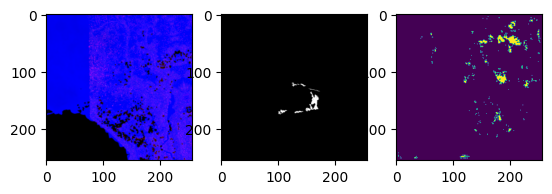

Epochs:3
Train_loss --> Dice: 0.07315062419307876 BCE: 0.011633979075212405 
Valid_loss --> Dice: 0.02259105578026612 BCE: 0.0032801435575617005
BEST EPOCH - Model Saved


29it [01:22,  2.83s/it]


KeyboardInterrupt: 

In [93]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

# print(np.shape(img))
# print(np.shape(mask))
for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('BEST EPOCH - Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

C:\Users\Orlan\AppData\Local\Temp\ipykernel_9628\1515324080.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt'))
C:\Users

F1-Score: 63.38816347295234
F1-Score: 0.8303677342823249
F1-Score: 25.029515938606853
F1-Score: 0.18273184102329829
F1-Score: 43.281677301731996
F1-Score: 11.29883843717001
F1-Score: 27.667109340416115
F1-Score: 44.46481778592712
F1-Score: 0.4373177842565598
F1-Score: 29.15254237288136
F1-Score: 13.124656781987918
F1-Score: 0.12437810945273631
F1-Score: nan
F1-Score: 0.18298261665141813


C:\Users\Orlan\AppData\Local\Temp\ipykernel_9628\1515324080.py:35: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 200 * (precision * recall) / (precision + recall)


F1-Score: 1.4355874574990557
F1-Score: 53.458745088701036
F1-Score: 31.841652323580032
F1-Score: 3.833736884584342
F1-Score: 29.13553895410886
F1-Score: 5.63230605738576
F1-Score: 10.976058931860038
F1-Score: 15.928322548531607
F1-Score: 1.2069577564785234
F1-Score: 9.3354943273906


C:\Users\Orlan\AppData\Local\Temp\ipykernel_9628\1515324080.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1,4)


F1-Score: 12.198795180722893
F1-Score: 13.491525423728811
F1-Score: 5.756666078050503
F1-Score: 1.6983695652173911


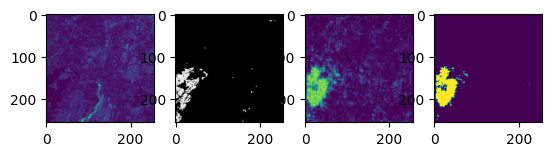

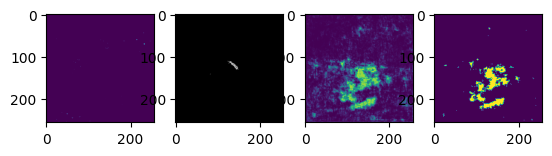

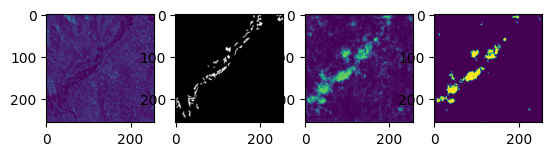

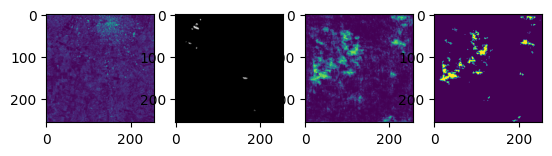

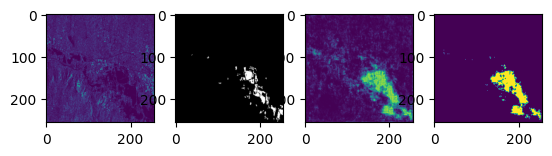

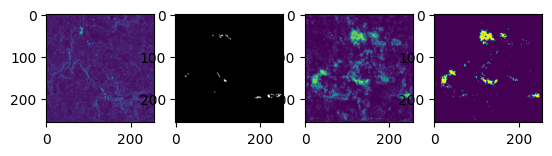

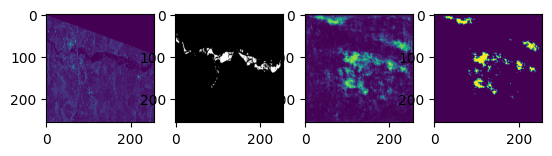

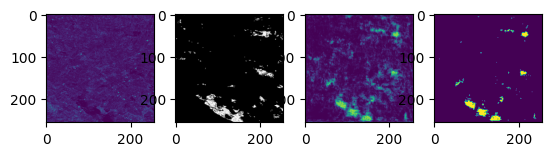

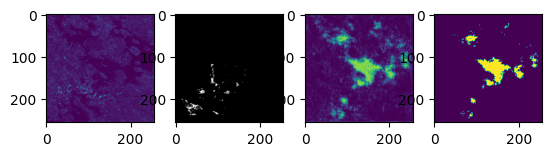

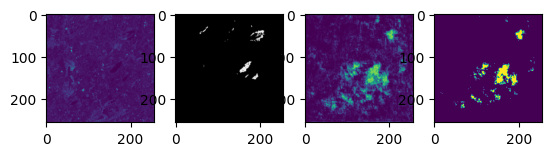

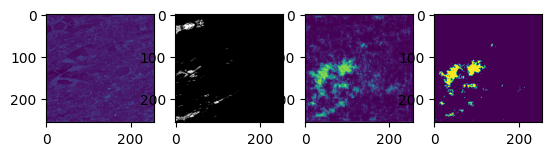

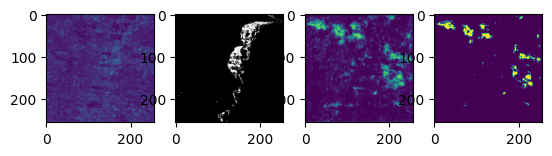

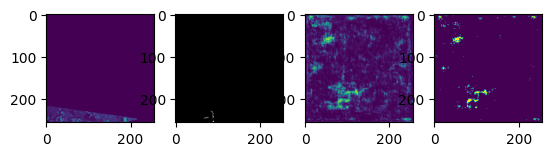

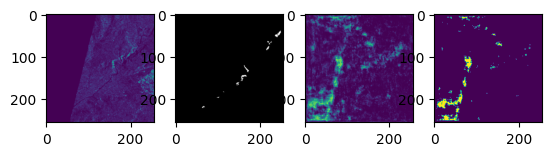

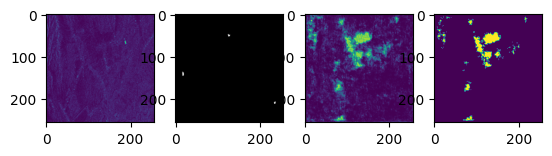

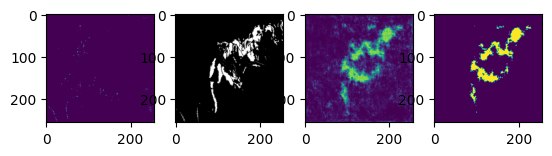

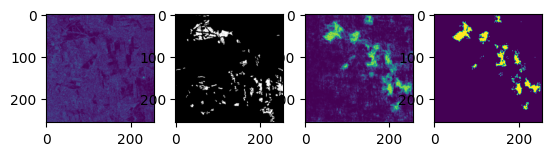

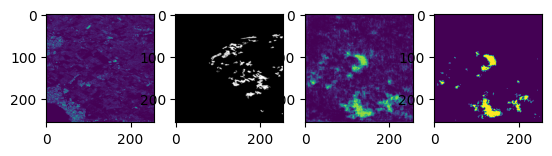

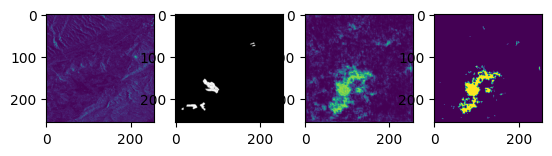

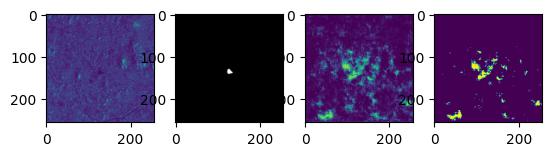

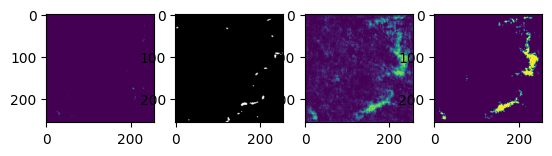

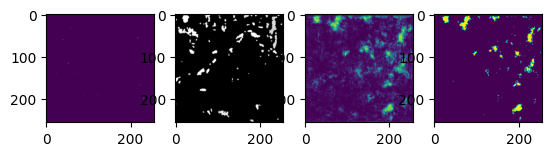

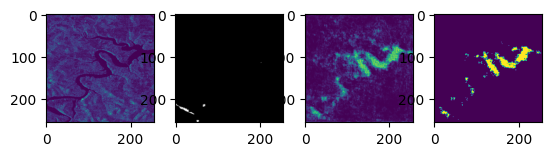

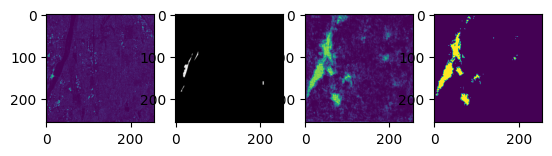

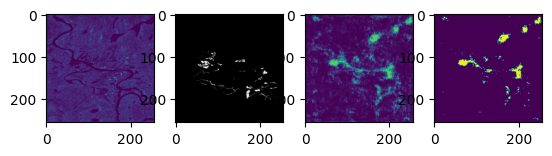

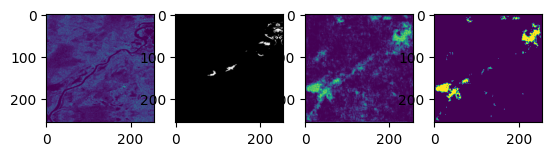

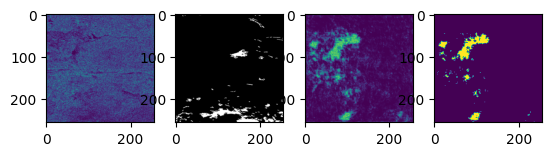

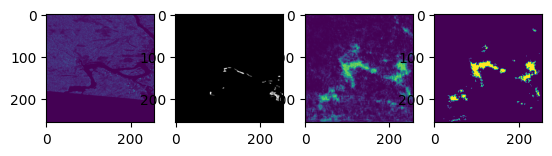

In [118]:
from sklearn.metrics import confusion_matrix
num=4
ratio=0.3

model.load_state_dict(torch.load('./best_model.pt'))

# Convert DataLoader to List
valid_loader_list = list(valid_loader)
# Select a Random Element
for i in range(11, len(valid_loader_list)):
    img= valid_loader_list[i]["images"][num]
    mask= valid_loader_list[i]["segmentation_masks"][num]
    logits_mask=model(img.to('cuda', dtype=torch.float32).unsqueeze(0))
    pred_mask=torch.sigmoid(logits_mask)

    predicted_full = pred_mask.detach().cpu().numpy()
    predicted_full =np.where(predicted_full>ratio, 1, 0)
    predicted = predicted_full.flatten()
    predicted = np.round(predicted).astype(int)
    
    actual = mask.flatten().detach().cpu().numpy()
    actual = np.round(actual).astype(int)

    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    conf_matrix = np.array([[tn, fp],
                                            [fn, tp]])

    # print("percent correct", 100*(tn+tp)/conf_matrix.sum())
    # print("Percentage correct when predicted flooded", 100*(tp)/(fp+tp))
    # print("Percentage flase negatives", 100*(fn)/conf_matrix.sum())
    # print(conf_matrix)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 200 * (precision * recall) / (precision + recall)
    print("F1-Score:", f1_score)

    f, axarr = plt.subplots(1,4) 
    axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
    axarr[0].imshow(np.log10(img[1, :, :].numpy()+1))
    axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
    axarr[3].imshow(np.transpose(predicted_full[0], (1,2,0)))